In [1]:
import os
import numpy as np
import math
import copy
import random
import pandas as pd
import copy
from scipy.optimize import minimize_scalar
from numpy.polynomial import polynomial as P
from tqdm import tqdm

In [29]:
#define theta
power_s = int(input("Enter degree of polynomial of simulator: "))
power_m = int(input("Enter degree of polynomial of model: "))
theta_input = []
for i in range(power_s+1):
  a = float(input('Enter coefficient of polynomial: '))
  theta_input.append(a)

Enter degree of polynomial of simulator: 2
Enter degree of polynomial of model: 2
Enter coefficient of polynomial: 0
Enter coefficient of polynomial: 1.1
Enter coefficient of polynomial: -0.5


In [30]:
if (power_m>power_s):
  for i in range(power_m-power_s):
    theta_input.append(0)

In [31]:
theta_input

[0.0, 1.1, -0.5]

In [32]:
#defining bounds
bound_s = 0.75
bound_e = 2

In [33]:
#Noise
mu = 0
sd = 0.1

In [34]:
#Getting actual reward value
def fu(x,power,theta):
  a = 0
  for i in range(power+1):
    a += theta[i]*(x**i)
  return a

In [35]:
#finding maximum value of function f(x)
max_x = minimize_scalar(lambda x: -fu(x,power_s,theta_input),bounds=(bound_s, bound_e), method='bounded')
max_act = max_x.x
max_f = fu(max_x.x,power_s,theta_input)
print('Actual Reward maxima at :',max_act)
print('Actual Reward maximum value:',max_f)

Actual Reward maxima at : 1.0999999999999999
Actual Reward maximum value: 0.6050000000000001


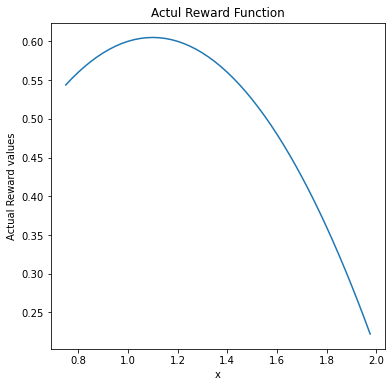

In [36]:
#plotting function f(x) for better visualisation
import matplotlib.pyplot as plt
act_rew_val = []
x_axis = np.arange(bound_s,bound_e,0.025)
for i in x_axis:
  act_rew_val.append(fu(i,power_s,theta_input))

f1 = plt.figure()
f1.set_figwidth(6)
f1.set_figheight(6)
plt.plot(x_axis,act_rew_val)
plt.xlabel('x')
plt.ylabel('Actual Reward values')
plt.title('Actul Reward Function')
plt.show()

**Polynomial LinUCB**

In [37]:
#polynomial function
def poly(x):
  f = []
  r = []
  r.append(1)
  for i in range(1,power_m+1):
    r.append(x**i)
  f.append(r)
  return f

Function to update matrix A

In [38]:
#update matrix A
def update_A(a):
  # A = np.array([[1,a,a**2]])
  return np.matmul(np.transpose(poly(a)),poly(a))

In [39]:
update_A(2)

array([[ 1,  2,  4],
       [ 2,  4,  8],
       [ 4,  8, 16]])

Function to update B vector

In [40]:
# update vector b
def updateBB(a):
  # B = np.array([[1,a,a**2]])
  return np.transpose(poly(a))

In [41]:
updateBB(2)

array([[1],
       [2],
       [4]])

UCB Function

In [42]:
#ucb function

## Estimation ##
def ucb(A,pol,theta):
    #norm of vector pol wrt matrix A
    n1 = np.matmul(pol,A)
    n2 = np.matmul(n1,np.transpose(pol))
    #Multiplication of coefficient theta with polynomial
    n3 = np.matmul(pol,theta)
    return n3[0][0] + alpha*np.sqrt(n2[0][0])

In [16]:
# Initializing theta 
theta = np.random.normal(0,1/(power_m+1),size=(power_m+1,1))
print('theta_0: \n',theta)

theta_0: 
 [[ 0.20911323]
 [-0.56546189]
 [ 0.11340016]]


In [67]:
## Initializing parameters and hyperparameters

# Total time step
T = 10000

sample = 100
# Intializing value of lambda which helps in initializing matrix A
lambd = 1

# Matrix A which updates theta, here written as LAMBDA
LAMBDA = lambd * np.identity(power_m+1, dtype= np.double)
print('A0: \n', LAMBDA)

# B vector which also updates theta, here written as bb
bb = np.zeros((power_m+1,1),dtype= np.double)
print('b0: \n',bb)


#Original theta
theta_org = theta_input
print('Original theta', theta_org)

# Alpha will control exploitation-exploration trade-off
alpha = 0.7


a_0 = np.linalg.inv(LAMBDA)  #A0 inverse


A0: 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
b0: 
 [[0.]
 [0.]
 [0.]]
Original theta [0.0, 1.1, -0.5]


Random Initialisation

In [68]:
# Loop T iteration

result_2d = []
theta_2d = []
action_2d = []
ra = np.arange(bound_s,bound_e,0.025)   ##range
for s in tqdm(range(sample),desc = 'Sample'):
    theta = np.random.normal(0,1/(power_m+1),size=(power_m+1,1))
    lambd = 1
    LAMBDA = lambd * np.identity(power_m+1, dtype= np.double)
    bb = np.zeros((power_m+1,1),dtype= np.double)
    a_0 = np.linalg.inv(LAMBDA)  #A0 inverse
    theta_rand = theta
    result_neuralucb = []
    # Store all values of action choosen
    action_chosen = []
    for t in range(0, T):
        noise = np.random.normal(mu,sd,1)
        
        if (t==0):
            #matrix A initialize with A_0
            a_sol = a_0
        


        ## OPTIMIZATION ##

        #choosen arm, maximum of ucb function will get us best arm
        ucb_val = []
        
        if (t==0):
            a_c = np.random.uniform(bound_s,bound_e,1)
            a_c = a_c[0]
        else:
          for i in ra:
            ucb_val.append(ucb(a_sol,poly(i),theta_rand))
          a_c = bound_s + (ucb_val.index(max(ucb_val)))*0.025
        # print('a_c',a_c)



        ## SIMULATION ##

        # Current Reward
        act_rew = fu(a_c,power_s,theta_input) + noise

        # print('actual reward: ',act_rew)
        #difference between maximum reward and current reward
        summ = (max_f-act_rew[0])
        result_neuralucb.append(summ)


        ## Appending action choosen at all iteration
        action_chosen.append(a_c)
        
        # update LAMBDA and bb
        LAMBDA += update_A(a_c)
        bb += act_rew * updateBB(a_c)
        aa = np.linalg.inv(LAMBDA)
        a_sol = aa
        theta_rand = np.matmul(aa,bb)
        #### Loop end

    result_2d.append(result_neuralucb)
    theta_2d.append(theta_rand)
    action_2d.append(action_chosen)

# print('2 d list',result_2d)
avg_regret = np.average(result_2d,axis = 0)

avg_cumulative_regret_rand = np.cumsum(avg_regret)

#avg theta
avg_theta_rand = np.average(theta_2d, axis = 0)

#avg action
avg_action_chosen_rand = np.average(action_2d, axis = 0)

# print('avg regret',avg_regret)

# print('avg cumalative',avg_cumulative_regret)


print('\nTheta after',T,'iteration: \n',avg_theta_rand)
# for pr in range(power_m+1):
#   print(theta[pr][0],'x^',pr)
## Storing action choosen by algorithm and cumulative Regret at each iteration in pandas data frame
df =  pd.DataFrame(list(zip(avg_action_chosen_rand,avg_cumulative_regret_rand)),columns=['Action Choosen','Average Cumulative Regret'])
df.head(20)

Sample: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [12:44<00:00,  7.64s/it]


Theta after 10000 iteration: 
 [[ 0.28212168]
 [ 0.58563739]
 [-0.26755977]]


,Action Choosen,Average Cumulative Regret
0,1.402162,0.110801
1,1.975000,0.486897
2,1.938250,0.838592
3,1.387000,1.064565
4,0.848000,1.149687
5,0.860250,1.261915
6,0.835750,1.347214
7,0.823500,1.438536
8,0.811250,1.519962
9,0.811250,1.575116


Barycentric spanner

In [69]:
# Loop T iteration

result_2d = []
theta_2d = []
action_2d = []
ra = np.arange(bound_s,bound_e,0.025)   ##range
for s in tqdm(range(sample),desc = 'Sample'):
    theta = np.random.normal(0,1/(power_m+1),size=(power_m+1,1))
    lambd = 1
    LAMBDA = lambd * np.identity(power_m+1, dtype= np.double)
    bb = np.zeros((power_m+1,1),dtype= np.double)
    a_0 = np.linalg.inv(LAMBDA)  #A0 inverse
    theta_baseline = theta
    result_neuralucb = []
    # Store all values of action choosen
    action_chosen = []
    for t in range(0, T):
        
        if (t==0):
            #matrix A initialize with A_0
            a_sol = a_0
        


        ## OPTIMIZATION ##

        #choosen arm, maximum of ucb function will get us best arm
        ucb_val = []
        
        #if (t==0):
            # a_c = np.random.uniform(bound_s,bound_e,1)
            # a_c = a_c[0]
            #a_c = bound_s
        #elif (t==1):
            #a_c = ((1/2)-np.sqrt(1/20))*(bound_e-bound_s) + bound_s
        #elif (t==2):
         #   a_c = ((1/2)+np.sqrt(1/20))*(bound_e-bound_s) + bound_s
        #elif (t==3):
         #   a_c = bound_e
        if (t==0):
            a_c = bound_s
        elif (t==1):
            a_c = (bound_s+bound_e)/2
        elif (t==2):
            a_c = bound_e
        else:
            for i in ra:
                ucb_val.append(ucb(a_sol,poly(i),theta_baseline))
            a_c = bound_s + (ucb_val.index(max(ucb_val)))*0.025
        # print('a_c',a_c)



        ## SIMULATION ##

        # Current Reward
        noise = np.random.normal(mu,sd,1)
        act_rew = fu(a_c,power_s,theta_input) + noise

        # print('actual reward: ',act_rew)
        #difference between maximum reward and current reward
        summ = (max_f-act_rew[0])
        result_neuralucb.append(summ)



        
        ## Appending action choosen at all iteration
        action_chosen.append(a_c)
        
        # update LAMBDA and bb
        LAMBDA += update_A(a_c)
        bb += act_rew * updateBB(a_c)
        aa = np.linalg.inv(LAMBDA)
        a_sol = aa
        theta_baseline = np.matmul(aa,bb)
        #### Loop end

    result_2d.append(result_neuralucb)
    theta_2d.append(theta_baseline)
    action_2d.append(action_chosen)

# print('2 d list',result_2d)
avg_regret_baseline = np.average(result_2d,axis = 0)

avg_cumulative_regret_baseline = np.cumsum(avg_regret_baseline)

#avg theta
avg_theta_baseline = np.average(theta_2d, axis = 0)

#avg action
avg_action_chosen_baseline = np.average(action_2d, axis = 0)

# print('avg regret',avg_regret)

# print('avg cumalative',avg_cumulative_regret)


print('\nTheta after',T,'iteration: \n',avg_theta_baseline)
# for pr in range(power_m+1):
#   print(theta[pr][0],'x^',pr)
## Storing action choosen by algorithm and cumulative Regret at each iteration in pandas data frame
df =  pd.DataFrame(list(zip(avg_action_chosen_baseline,avg_cumulative_regret_baseline)),columns=['Action Choosen','Average Cumulative Regret'])
df.head(20)

Sample: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [12:51<00:00,  7.71s/it]


Theta after 10000 iteration: 
 [[ 0.28227088]
 [ 0.58604024]
 [-0.26816129]]


,Action Choosen,Average Cumulative Regret
0,0.75000,0.061009
1,1.37500,0.064656
2,2.00000,0.468788
3,1.93825,0.839567
4,1.21550,1.042989
5,0.97050,1.159491
6,0.81125,1.244617
7,0.84800,1.350650
8,0.86025,1.443501
9,0.81125,1.533393


Iterative Least Square

In [70]:
#ils method
result_2d = []
theta_2d = []
action_2d = []
theta_ils = theta
for s in tqdm(range(sample),desc = 'Sample'):
    x = np.random.uniform(bound_s,bound_e,1)
    action_chosen_ils = []
    result_ils = []
    for t in range(T):
        noise = np.random.normal(mu,sd,1)
        if (t==0):
            y = fu(x,power_s,theta_input) + noise
        else:
            temp = fu(x[-1],power_s,theta_input)
            y = np.append(y,temp)
        c_ils,stats_ils = P.polyfit(x,y,power_m,full=True)
        max_m = minimize_scalar(lambda z: -fu(z,power_m,c_ils),bounds=(bound_s, bound_e), method='bounded')
        max_val = max_m.x
        action_chosen_ils.append(max_val)
        x = np.append(x,max_val)
        #simulator reward
        act_reward = fu(max_val,power_s,theta_input) + noise
        #regret
        summ = max_f - act_reward[0]
        result_ils.append(summ)
        ## Appending action choosen at all iteration
        action_chosen_ils.append(max_val)
    result_2d.append(result_ils)
    theta_2d.append(c_ils)
    action_2d.append(action_chosen_ils)

#avg regret
avg_regret_ils = np.average(result_2d,axis = 0)

avg_cumulative_regret_ils = np.cumsum(avg_regret_ils)

#avg theta
avg_theta_ils = np.average(theta_2d, axis = 0)

#avg action
avg_action_chosen_ils = np.average(action_2d, axis = 0)
avg_theta_ils1 = np.array([avg_theta_ils])
avg_theta_ils1 = avg_theta_ils1.reshape(power_m+1,1)

print('\nTheta after',T,'iteration: \n',avg_theta_ils1)

df =  pd.DataFrame(list(zip(avg_action_chosen_ils,avg_cumulative_regret_ils)),columns=['Action Choosen','Average Cumulative Regret'])
df.head(20)

Sample: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [07:36<00:00,  4.56s/it]



Theta after 10000 iteration: 
 [[ 0.11198888]
 [ 0.59192769]
 [-0.2730624 ]]


,Action Choosen,Average Cumulative Regret
0,1.987496,0.402128
1,1.987496,0.487251
2,0.837504,0.545035
3,0.837504,0.592085
4,1.126065,0.630726
5,1.126065,0.678697
6,1.089317,0.713056
7,1.089317,0.757200
8,1.086117,0.800643
9,1.086117,0.828729


Constrained Iterative Least Square Method

In [71]:
#cils method
#for cils value of k
k = 0.1
result_2d = []
theta_2d = []
action_2d = []
for s in tqdm(range(sample),desc = 'Sample'):
    x = np.random.uniform(bound_s,bound_e,1)
    action_chosen_cils = []
    result_cils = []
    max_avg = 0
    max_sum = 0
    for t in range(T):
        noise = np.random.normal(mu,sd,1)
        if (t==0):
            y = fu(x,power_s,theta_input) + noise
        else:
            temp = fu(x[-1],power_s,theta_input) + noise
            y = np.append(y,temp)
        
        c_cils,stats = P.polyfit(x,y,power_m,full=True)
        max_m = minimize_scalar(lambda x: -fu(x,power_m,c_cils),bounds=(bound_s, bound_e), method='bounded')
        max_val = max_m.x
        if (t==0):
            max_sum = max_val
        if (t>0):
            max_avg = max_sum/t
            delta_t = np.abs(x[t-1] - max_avg)
            if (delta_t < (k/(t**(1/4))) ):
                max_val = max_avg + np.sign(delta_t)*k*(t**(-1/4))
        max_sum += max_val
        action_chosen_cils.append(max_val)
        x = np.append(x,max_val)
        #regret
        act_reward = fu(max_val,power_s,theta_input) + noise
        summ = max_f - act_reward[0]
        result_cils.append(summ)
    result_2d.append(result_cils)
    theta_2d.append(c_cils)
    action_2d.append(action_chosen_cils)

#avg regret
avg_regret_cils = np.average(result_2d,axis = 0)

avg_cumulative_regret_cils = np.cumsum(avg_regret_cils)

#avg theta
avg_theta_cils = np.average(theta_2d, axis = 0)

#avg action
avg_action_chosen_cils = np.average(action_2d, axis = 0)

avg_theta_cils1 = np.array([avg_theta_cils])
avg_theta_cils1 = avg_theta_cils1.reshape(power_m+1,1)

print('\nTheta after',T,'iteration: \n',avg_theta_cils1)


df =  pd.DataFrame(list(zip(avg_action_chosen_cils,avg_cumulative_regret_cils)),columns=['Action Choosen','Average Cumulative Regret'])
df.head(20)

Sample: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:06<00:00,  3.67s/it]



Theta after 10000 iteration: 
 [[-0.14434027]
 [ 1.26839075]
 [-0.55375117]]


,Action Choosen,Average Cumulative Regret
0,1.999996,0.391789
1,0.826807,0.480312
2,1.101418,0.505888
3,1.037761,0.560228
4,1.025067,0.610937
5,1.028471,0.637073
6,1.034604,0.671888
7,1.033269,0.692225
8,1.046741,0.715766
9,1.045745,0.752512


**Theta Comparison**

In [77]:
th_comp = pd.DataFrame()
th_comp['Original Theta'] = theta_input
# th_comp['Initial Theta'] = theta
th_comp['Random Initialisation Theta'] = avg_theta_rand
th_comp['Barycenteric Method Theta'] = avg_theta_baseline
th_comp['ILS Theta'] = avg_theta_ils1
th_comp['CILS Theta'] = avg_theta_cils1

In [78]:
th_comp

,Original Theta,Random Initialisation Theta,Barycenteric Method Theta,ILS Theta,CILS Theta
0,0.0,0.282122,0.282271,0.111989,-0.144340
1,1.1,0.585637,0.586040,0.591928,1.268391
2,-0.5,-0.267560,-0.268161,-0.273062,-0.553751


**Regret Comparison**

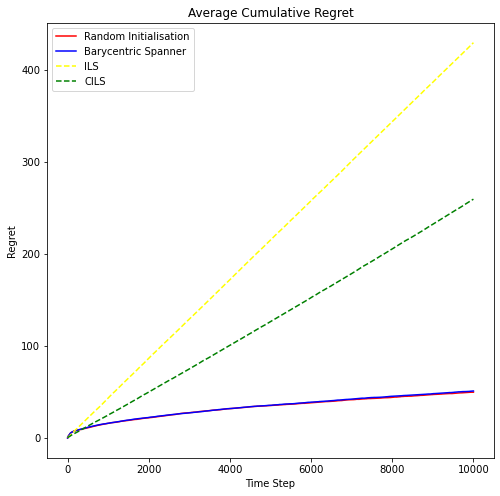

In [83]:
# Cumulative Regret plot
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.plot(avg_cumulative_regret_rand, color = 'red')
plt.plot(avg_cumulative_regret_baseline,color = 'blue')
plt.plot(avg_cumulative_regret_ils,color = 'yellow',linestyle='dashed')
plt.plot(avg_cumulative_regret_cils,color = 'green',linestyle='dashed')
plt.legend(['Random Initialisation','Barycentric Spanner','ILS','CILS'], loc = "upper left")
plt.xlabel('Time Step')
plt.ylabel('Regret')
plt.title('Average Cumulative Regret')
f.savefig('regret.png')
plt.show()

In [80]:
def th(theta,x):
  a = 0
  for i in range(power_m+1):
    a += theta[i]*(x**i)
  return a

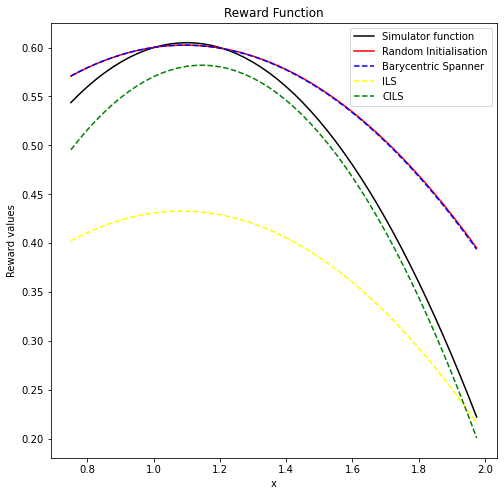

In [84]:
import matplotlib.pyplot as plt
act_rew_val = []
act_rew_val_rand = []
act_rew_val_baseline = []
act_rew_val_ils = []
act_rew_val_cils = []
x_axis = np.arange(bound_s,bound_e,0.025)
for i in x_axis:
    act_rew_val.append(fu(i,power_s,theta_input))
    act_rew_val_rand.append(fu(i,power_m,avg_theta_rand))
    act_rew_val_baseline.append(fu(i,power_m,avg_theta_baseline))
    act_rew_val_ils.append(fu(i,power_m,avg_theta_ils))
    act_rew_val_cils.append(fu(i,power_m,avg_theta_cils))
f1 = plt.figure()
f1.set_figwidth(8)
f1.set_figheight(8)
plt.plot(x_axis,act_rew_val,'black')
plt.plot(x_axis,act_rew_val_rand,color = 'red')
plt.plot(x_axis,act_rew_val_baseline,color = 'blue', linestyle='dashed')
plt.plot(x_axis,act_rew_val_ils,color = 'yellow', linestyle='dashed')
plt.plot(x_axis,act_rew_val_cils,color = 'green', linestyle='dashed')
plt.legend(['Simulator function','Random Initialisation','Barycentric Spanner','ILS','CILS'], loc = "upper right")
plt.xlabel('x')
plt.ylabel('Reward values')
plt.title('Reward Function')
plt.show()